# AdVitam Exp-4 | Multi-channel Spectrogram Baseline

Interactive baseline pipeline for AdVitam-Exp4 sleepiness detection.

Pipeline steps
--------------
1. Load raw BioPac `.acq` files (ECG, EDA, RESP)
2. Band-pass filter 0.5–40 Hz and decimate from 1000 Hz → 250 Hz
3. Slice into 30 s windows with 7.5 s hop
4. Compute log-power STFT spectrogram for each channel
5. Align every window to a linearly-interpolated KSS target (5-min chunks)
6. Train a tiny CNN with 5-fold subject-grouped CV (batch 128, 3 epochs)
   • Regression head → continuous KSS
   • Classification head → 3 drowsiness classes


In [ ]:
from __future__ import annotations

import math
import random
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import scipy.signal as sig
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.autolayout": True})

# Configuration



In [ ]:
from pathlib import Path
project_root = Path.cwd().resolve().parent
# ------------------------------------------------------------------
#  Dataset locations – hard-coded, no env / utils import
# ------------------------------------------------------------------
RAW_DIR       = Path(f"{project_root}/data/AdVitam/Raw/Physio/BioPac")
QUESTIONNAIRE = Path(f"{project_root}/data/AdVitam/Preprocessed/Questionnaire/Exp4_Database.csv")

assert RAW_DIR.exists(),       "Raw directory missing"
assert QUESTIONNAIRE.exists(), "Questionnaire CSV missing"

In [ ]:
FS_RAW, FS = 1000, 250
BP_LO, BP_HI = 0.5, 40
WINDOW_SEC, HOP_SEC = 30, 7.5
N_FFT, WIN_LEN, HOP_LEN = 256, 256, 128
FREQ_MAX = 50
BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- toggle ---------------------------------------------------------------
BINARY_KSS = True  # True ➜ 2-class mapping (≤6 sleepy? No, ≤6 alert(0), ≥7 sleepy(1))
N_CLASSES = 2 if BINARY_KSS else 3

# Signal helpers


In [ ]:

def bandpass(x: np.ndarray, lo: float = BP_LO, hi: float = BP_HI, fs: int = FS_RAW, order: int = 4) -> np.ndarray:
    b, a = sig.butter(order, [lo / (0.5 * fs), hi / (0.5 * fs)], "band")
    return sig.filtfilt(b, a, x)


def decimate_250(x: np.ndarray) -> np.ndarray:
    factor = FS_RAW // FS
    return sig.decimate(x, factor, ftype="fir", zero_phase=True)


def read_biopac(acq: Path) -> Dict[str, np.ndarray]:
    import bioread

    data = bioread.read_file(acq)
    out = {"ECG": None, "EDA": None, "RESP": None}
    for ch in data.channels:
        n = ch.name.lower()
        if "ecg" in n:
            out["ECG"] = ch.data.astype(np.float32)
        if "eda" in n:
            out["EDA"] = ch.data.astype(np.float32)
        if "resp" in n:
            out["RESP"] = ch.data.astype(np.float32)
    max_len = max(len(s) for s in out.values() if s is not None)
    for k, v in out.items():
        if v is None:
            out[k] = np.zeros(max_len, np.float32)
    return out


def block_starts(acq: Path) -> Dict[str, float]:
    import bioread

    starts = {}
    for mk in getattr(bioread.read_file(acq), "event_markers", []):
        t = mk.text.strip()
        if t.endswith("Start"):
            starts[t] = mk.sample_index / FS_RAW
    return starts


def stft_db(sig1d: np.ndarray) -> np.ndarray:
    f, _, Z = sig.stft(
        sig1d,
        fs=FS,
        window="hann",
        nperseg=WIN_LEN,
        noverlap=WIN_LEN - HOP_LEN,
        nfft=N_FFT,
        boundary=None,
        padded=False,
    )
    return 10 * np.log10(np.abs(Z[f <= FREQ_MAX]) ** 2 + 1e-12)


def interp_kss(row: pd.Series, parts: int = 6) -> Tuple[np.ndarray, np.ndarray]:
    return (
        np.linspace(row["KSS_B_1"], row["KSS_1"], parts),
        np.linspace(row["KSS_B_2"], row["KSS_2"], parts),
    )


In [ ]:
def build_dataset() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Construct the spectrogram dataset.

    Returns
    -------
    X : np.ndarray
        Spectrogram tensor of shape (N, 3, F, T) where
        N = number of 30-s windows,
        3 = channels (ECG, EDA, RESP),
        F = frequency bins (≤ FREQ_MAX),
        T = STFT time bins.
    y : np.ndarray
        Target KSS value for every window, shape (N, ).
    subj : np.ndarray
        Subject ID string for every window, shape (N, ).
    """
    spectros, targets, subjects = [], [], []

    # ---------- 1) Load questionnaire for KSS scores ----------
    quest = pd.read_csv(QUESTIONNAIRE)

    # ---------- 2) Iterate over every .acq recording ----------
    for acq in sorted(RAW_DIR.glob("*.acq")):
        pid = acq.stem.split("_")[0]                                 # e.g. "060"
        qmatch = quest[quest["participant_code"].astype(str).str.startswith(pid)]
        if qmatch.empty:                                             # skip if questionnaire missing
            continue
        row = qmatch.iloc[0]

        # Linear-interpolate 6 five-minute KSS targets for each block
        kss1, kss2 = interp_kss(row)                                 # (6,), (6,)
        order = int(row["order_scenario"])                           # which scenario came first

        # ---------- 3) Read and preprocess physiology ----------
        sigs = read_biopac(acq)                                      # dict[ECG/EDA/RESP] → 1-d array
        for k in sigs:                                               # band-pass & downsample each channel
            sigs[k] = decimate_250(bandpass(sigs[k]))
        min_len = min(map(len, sigs.values()))                       # trim to the shortest channel
        sigs = {k: v[:min_len] for k, v in sigs.items()}

        # Locate “Block 1 Start” / “Block 2 Start” markers
        starts = block_starts(acq)
        if not {"Block1 Start", "Block2 Start"}.issubset(starts):
            continue                                                 # skip malformed recording
        b1, b2 = starts["Block1 Start"], starts["Block2 Start"]      # times in seconds

        # ---------- 4) Helper to slice one 30-min block ----------
        def process_block(t0: float, kss_chunks: np.ndarray) -> None:
            blk_len = 30 * 60 * FS                                   # 30 min in samples
            s0 = int(t0 * FS)                                        # block start sample index
            if s0 + blk_len > min_len:                               # incomplete recording
                return
            win, hop = int(WINDOW_SEC * FS), int(HOP_SEC * FS)
            for off in range(0, blk_len - win + 1, hop):             # slide 30-s window (7.5-s hop)
                sl = slice(s0 + off, s0 + off + win)
                # Compute 3-channel spectrogram, stack into (3,F,T)
                spec_ch = [stft_db(sigs[ch][sl]) for ch in ("ECG", "EDA", "RESP")]
                spectros.append(np.stack(spec_ch, dtype=np.float32))

                # Assign KSS: figure out which 5-min chunk this window’s midpoint falls in
                mid_sec = (off + win / 2) / FS                       # seconds from block start
                idx = min(int(mid_sec // (5 * 60)), 5)               # chunk index 0-5
                targets.append(float(kss_chunks[idx]))
                subjects.append(pid)

        # ---------- 5) Process the two blocks in the correct order ----------
        if order == 1:                                               # scenario A then B
            process_block(b1, kss1)
            process_block(b2, kss2)
        else:                                                        # scenario B then A
            process_block(b1, kss2)
            process_block(b2, kss1)

    # ---------- 6) Final tensor assembly ----------
    X = np.stack(spectros)                                           # (N, 3, F, T)
    y = np.array(targets, dtype=np.float32)
    subj = np.array(subjects)
    print("Dataset:", X.shape)
    return X, y, subj

# Model


In [ ]:
class SpectroCNN(nn.Module):
    def __init__(self, n_classes: int = N_CLASSES):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((4, 4)),
        )
        self.flat = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(32 * 4 * 4, 64), nn.ReLU())
        self.reg_head = nn.Linear(64, 1)
        self.cls_head = nn.Linear(64, n_classes)

    def forward(self, x: torch.Tensor):
        x = self.trunk(x)
        x = self.flat(x)
        x = self.fc(x)
        return self.reg_head(x).squeeze(1), self.cls_head(x)


# Helpers   

In [ ]:

def kss_to_class(kss: np.ndarray) -> np.ndarray:
    if BINARY_KSS:
        return (kss >= 7).astype(np.int64)  # 0 or 1
    return np.digitize(kss, [5, 7]).astype(np.int64)  # 0,1,2


def plot_cm(cm: np.ndarray, fold: int):
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Fold {fold} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def run_fold(train_dl: DataLoader, val_dl: DataLoader, fold: int):
    model = SpectroCNN().to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    reg_crit, cls_crit = nn.MSELoss(), nn.CrossEntropyLoss()

    for ep in range(1, EPOCHS + 1):
        model.train()
        for xb, y_r, y_c in train_dl:
            xb, y_r, y_c = xb.to(DEVICE), y_r.to(DEVICE), y_c.to(DEVICE)
            opt.zero_grad()
            p_r, p_c = model(xb)
            loss = reg_crit(p_r, y_r) + cls_crit(p_c, y_c)
            loss.backward()
            opt.step()
        print(f"  Fold {fold} Epoch {ep} done")

    model.eval()
    pr_r, pr_c, tr_r, tr_c = [], [], [], []
    with torch.no_grad():
        for xb, y_r, y_c in val_dl:
            p_r, p_c = model(xb.to(DEVICE))
            pr_r.append(p_r.cpu()); pr_c.append(p_c.argmax(1).cpu())
            tr_r.append(y_r); tr_c.append(y_c)
    pr_r = torch.cat(pr_r).numpy(); pr_c = torch.cat(pr_c).numpy()
    tr_r = torch.cat(tr_r).numpy(); tr_c = torch.cat(tr_c).numpy()

    reg = {
        "MAE": mean_absolute_error(tr_r, pr_r),
        "RMSE": math.sqrt(mean_squared_error(tr_r, pr_r)),
        "R2": r2_score(tr_r, pr_r),
    }
    cm = confusion_matrix(tr_c, pr_c, labels=list(range(N_CLASSES)))
    plot_cm(cm, fold)
    cls = {"ACC": accuracy_score(tr_c, pr_c)}
    return reg, cls


## Run the experiment


In [ ]:
X, y, subj = build_dataset()
y_cls = kss_to_class(y)

Dataset: (17301, 3, 52, 57)


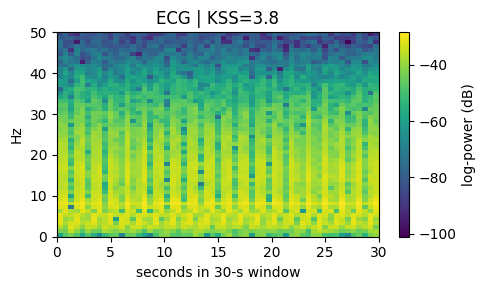

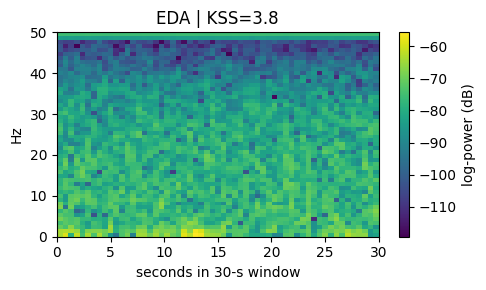

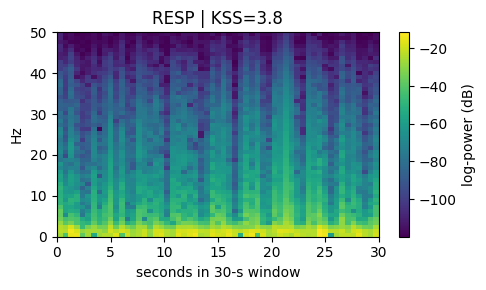

In [ ]:
ch_names = ["ECG", "EDA", "RESP"]
idx = 42                                    # any window
for ch in range(3):
    plt.figure(figsize=(5, 3))
    plt.imshow(
        X[idx, ch],
        origin="lower",
        aspect="auto",
        extent=[0, WINDOW_SEC, 0, FREQ_MAX],
        cmap="viridis",
    )
    plt.title(f"{ch_names[ch]} | KSS={y[idx]:.1f}")
    plt.xlabel("seconds in 30-s window")
    plt.ylabel("Hz")
    plt.colorbar(label="log-power (dB)")
    plt.show()

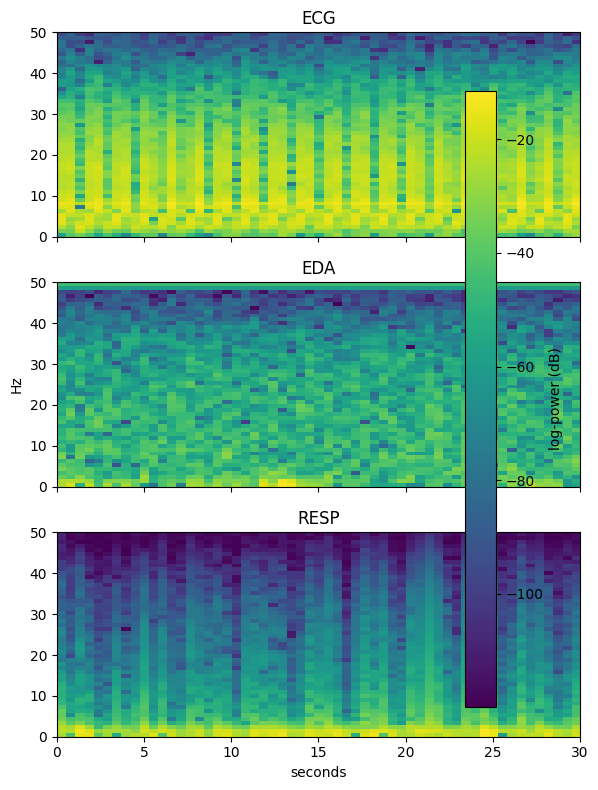

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)
for ch, ax in enumerate(axes):
    im = ax.imshow(
        X[idx, ch], origin="lower", aspect="auto",
        extent=[0, WINDOW_SEC, 0, FREQ_MAX], cmap="viridis"
    )
    ax.set_title(ch_names[ch])
fig.colorbar(im, ax=axes, orientation="vertical", label="log-power (dB)")
axes[-1].set_xlabel("seconds"); axes[1].set_ylabel("Hz")
plt.show()

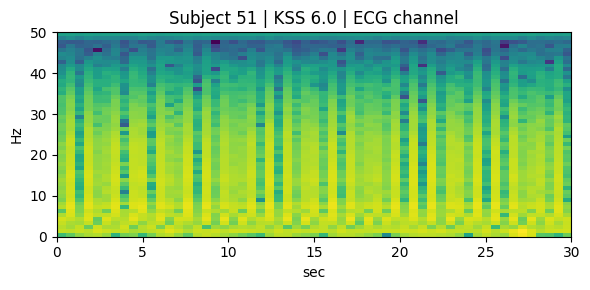

In [ ]:
# sanity-check spectrogram plot
idx = random.randrange(len(X))
plt.figure(figsize=(6, 3))
plt.imshow(X[idx, 0], origin="lower", aspect="auto", extent=[0, WINDOW_SEC, 0, FREQ_MAX])
plt.title(f"Subject {subj[idx]} | KSS {y[idx]:.1f} | ECG channel")
plt.xlabel("sec"); plt.ylabel("Hz")
plt.show()


  Fold 1 Epoch 1 done
  Fold 1 Epoch 2 done
  Fold 1 Epoch 3 done


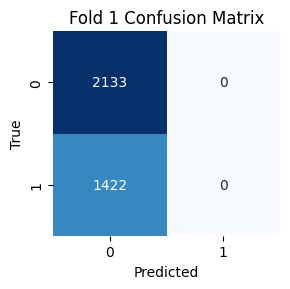

Fold 1 metrics 

		=> REG {'MAE': 1.443081021308899, 'RMSE': 1.620945273344494, 'R2': 0.04257059097290039}

		=> CLS {'ACC': 0.6}

  Fold 2 Epoch 1 done
  Fold 2 Epoch 2 done
  Fold 2 Epoch 3 done


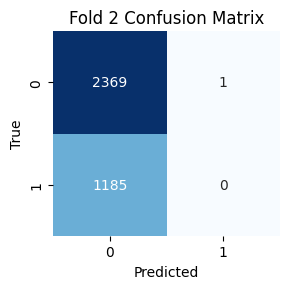

Fold 2 metrics 

		=> REG {'MAE': 1.788299322128296, 'RMSE': 2.124452183739058, 'R2': -0.19957172870635986}

		=> CLS {'ACC': 0.6663853727144866}

  Fold 3 Epoch 1 done
  Fold 3 Epoch 2 done
  Fold 3 Epoch 3 done


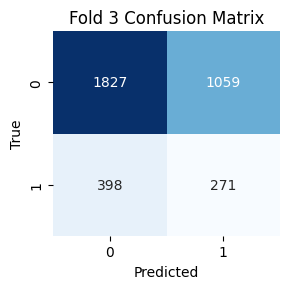

Fold 3 metrics 

		=> REG {'MAE': 1.5004394054412842, 'RMSE': 1.8784747034582587, 'R2': -0.3966482877731323}

		=> CLS {'ACC': 0.590154711673699}

  Fold 4 Epoch 1 done
  Fold 4 Epoch 2 done
  Fold 4 Epoch 3 done


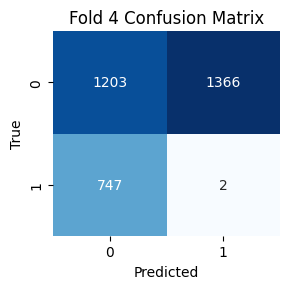

Fold 4 metrics 

		=> REG {'MAE': 2.045396566390991, 'RMSE': 2.2405658666237516, 'R2': -1.428276777267456}

		=> CLS {'ACC': 0.36317058468957203}

  Fold 5 Epoch 1 done
  Fold 5 Epoch 2 done
  Fold 5 Epoch 3 done


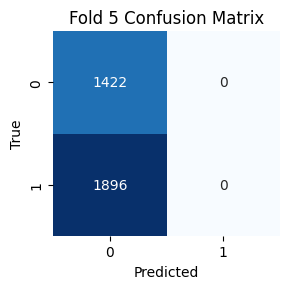

Fold 5 metrics 

		=> REG {'MAE': 1.7506866455078125, 'RMSE': 2.194366468447205, 'R2': -1.090266466140747}

		=> CLS {'ACC': 0.42857142857142855}

==== Mean over folds ====
{'MAE': 1.7055805921554565, 'RMSE': 2.0117608991225535, 'R2': -0.614438533782959, 'ACC': 0.5296564195298372}


In [ ]:

kf = GroupKFold(n_splits=5)
regs, clss = [], []
for fold, (tr, va) in enumerate(kf.split(X, y, groups=subj), 1):
    tr_ds = TensorDataset(torch.from_numpy(X[tr]), torch.from_numpy(y[tr]), torch.from_numpy(y_cls[tr]))
    va_ds = TensorDataset(torch.from_numpy(X[va]), torch.from_numpy(y[va]), torch.from_numpy(y_cls[va]))
    tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    va_dl = DataLoader(va_ds, batch_size=BATCH_SIZE)
    r, c = run_fold(tr_dl, va_dl, fold)
    regs.append(r); clss.append(c)
    print(f"Fold {fold} metrics \n")
    print(f"\t\t=> REG {r}\n")
    print(f"\t\t=> CLS {c}\n")

def avg(key: str, arr: List[dict]):
    return float(np.mean([d[key] for d in arr]))

print("==== Mean over folds ====")
print({
    "MAE": avg("MAE", regs),
    "RMSE": avg("RMSE", regs),
    "R2": avg("R2", regs),
    "ACC": avg("ACC", clss),
}) 